In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
import numpy as np
import utils

In [2]:
data_dir = "../../data/google_patents/24054-jp-patents"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 24054


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "title": str,
    "pdf": str,
    "description": List[str],      # should be concatenated
    "claims": List[str],
    "classifications": List[str],   # each string uses "\n" to separate the cluster ID and its description 
}
```

In [13]:
sample_doc_file = doc_files[2]
with open(sample_doc_file, "r") as f:
    sample_doc = json.load(f)
    print("Document attributes:", sample_doc.keys())

Document attributes: dict_keys(['title', 'pdf', 'classifications', 'description', 'claims'])


In [14]:
sample_doc["classifications"]

['A61N1/0456\nSpecially adapted for transcutaneous electrical nerve stimulation [TENS]',
 'A61N1/0526\nHead electrodes',
 'A61N1/0551\nSpinal or peripheral nerve electrodes',
 'A61N1/36017\nExternal stimulators, e.g. with patch electrodes with leads or electrodes penetrating the skin',
 'A61N1/36025\nExternal stimulators, e.g. with patch electrodes for treating a mental or cerebral condition',
 'A61N1/36031\nControl systems using physiological parameters for adjustment',
 'A61N1/36034\nControl systems specified by the stimulation parameters',
 'A61N1/36053\nImplantable neurostimulators for stimulating central or peripheral nerve system adapted for vagal stimulation',
 'A61N1/36064\nEpilepsy',
 'A61N1/36085\nEating disorders or obesity',
 'A61N1/36089\nAddiction or withdrawal from substance abuse such as alcohol or drugs',
 'A61N1/36096\nMood disorders, e.g. depression, anxiety or panic disorder',
 'A61N1/361\nPhantom sensations, e.g. tinnitus',
 'A61N1/36114\nCardiac control, e.g. by v

In [6]:
def get_id(doc_file_name):
    x = os.path.basename(doc_file_name)
    return os.path.splitext(x)[0]
    
def get_content(doc):
    return "\n".join(doc["claims"])

def get_label(doc):
    res = set(x.split("\n")[0][:4] for x in doc["classifications"])
    return list(res)
    
def get_title(doc):
    return doc["title"]

def get_sample(doc, fname):
    return {"id": get_id(fname), "title": get_title(doc), "content": get_content(doc), "labels": get_label(doc)}

In [7]:
samples = []
for fname in doc_files:
    with open(fname, "r") as fin:
        doc = json.load(fin)
        if get_label(doc):
            samples.append(get_sample(doc, fname))
            
doc_ids = random_state.permutation([x["id"] for x in samples if x["labels"]])
print("Number of valid documents:", len(doc_ids))

Number of valid documents: 23884


In [8]:
split_ids = {}
last_id = 0

for data_type in ("train", "dev", "test"):
    num_samples = int(data_ratio[data_type] * len(doc_ids))
    split_ids[data_type] = doc_ids[last_id : last_id + num_samples]
    last_id += num_samples
    
split_ids

{'train': array(['JP6602935B2', 'JP6641425B2', 'JP5752836B2', ..., 'JP6322694B2',
        'JP6432121B2', 'JP6659298B2'], dtype='<U11'),
 'dev': array(['JP5839139B2', 'JP6002828B2', 'JP6407981B2', ..., 'JP5890508B2',
        'JP6310978B2', 'JP6697636B2'], dtype='<U11'),
 'test': array(['JP6335260B2', 'JP5919344B2', 'JP6173359B2', ..., 'JP6195956B2',
        'JP6643958B2', 'JP6400728B2'], dtype='<U11')}

In [9]:
for sample in samples:
    id = sample["id"]
    sample["is_train"] = id in split_ids["train"]
    sample["is_dev"] = id in split_ids["dev"]
    sample["is_test"] = id in split_ids["test"]

In [10]:
labels = set()
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        if sample["labels"]:
            f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            labels.update(sample["labels"])

label_ids = {x : i for i, x in enumerate(sorted(labels))}
utils.dump_json(label_ids, save_label_path)

100%|██████████| 23884/23884 [00:00<00:00, 28563.92it/s]


In [11]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,content,labels,is_train,is_dev,is_test
0,JP6856713B2,合わせガラス用中間膜及び合わせガラスの製造方法,２層以上の樹脂層が積層された合わせガラス用中間膜であって、\n少なくとも一方の表面に、多数の...,"[B32B, C03C]",True,False,False
1,JP6856711B2,半導体装置,ゲート電極層と、\n 前記ゲート電極層上にゲート絶縁層と、\n 前記ゲート絶縁層上に酸化...,"[G02F, H01L]",True,False,False
2,JP6856704B2,医学的障害の治療のためのデバイス,医学的障害の治療のための三叉神経刺激のためのシステムであって、\n パルス発生器と、\n ...,[A61N],True,False,False
3,JP6856696B2,コンテナの管理及びスケジューリングのためのシステム,１つまたは複数のプロセッサと、\n 前記１つまたは複数のプロセッサによって実行される際、実...,[G06F],True,False,False
4,JP6856695B2,タービン・カートリッジを備えるオーバーハング・タービン及び発電機システム,シャフトと、\n ハウジングと、\n 複数の固定子板を含む少なくとも１つの固定子であって...,"[Y10T, F01K, F16C, Y02E, B23P, F05D, H02K, F01...",True,False,False
...,...,...,...,...,...,...,...
23879,JP3194731U,呼吸器及び呼吸器用選択素子,患者からの吐出気体のための気体経路に気体分離膜を有し、\nその気体分離膜は、希ガスが比較的低...,"[A61M, B01D, C01B]",True,False,False
23880,JP3194569U,保護カバー,収容部と、\n 前記収容部に設置される緩和部と、\nを備えてなる保護カバーであって、\n ...,"[B65D, A45C, H04B]",True,False,False
23881,JP3194297U,自動車用及び産業用のモーション感知制御装置,組み込み可能なモーション感知制御装置であって、\n 眺められている景色の立体的なイメージ情...,"[G06T, G06K, G01P, G06F, H04N]",True,False,False
23882,JP3193976U,過熱破壊式安全構造及び過熱破壊式安全構造を備えるコンセントとプラグ,２つの導電部材と、熱変形温度下で変形破壊する位置規制部材とを備える過熱破壊式安全構造であって...,[H01R],False,False,True


In [15]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(19107, 2388, 2388)

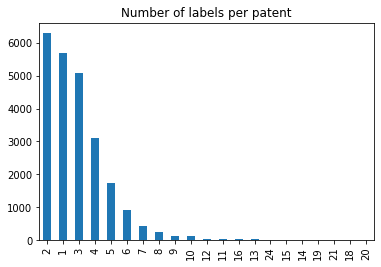

In [12]:
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");

In [17]:
df["content"].apply(lambda x : len(x.split())).mean()

44.22144531904204

In [18]:
len(label_ids)

555